In [1]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

## Plot Franke Function with noise

Text(0.5, 0.92, 'surface')

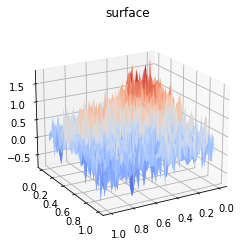

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from franke_function import FrankeFunction as Fr
from matplotlib import cm

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], y.shape[1])

z = Fr(x, y) + noise*0.3

ax = plt.subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap=cm.coolwarm)
ax.view_init(elev=20., azim=60)
ax.set_title('surface')

# Train - test split: Estimating MSE and R²

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from franke_function import FrankeFunction as Fr
from regression import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
x, y = np.meshgrid(x, y)

noise = np.random.randn(x.shape[0], x.shape[1])
#z_real = Fr(x, y)
z = Fr(x, y) + + noise*0
    
x_cent =  ((x - np.mean(x))/np.mean(x)).reshape(-1, 1)   
y_cent =  ((y - np.mean(y))/np.mean(y)).reshape(-1, 1) 
z_cent =  ((z - np.mean(z))/np.mean(z)).reshape(-1, 1) 

xy_cent_train, xy_cent_test, z_cent_train, z_cent_test = train_test_split(np.hstack([x_cent, y_cent]), z_cent)
    
MSE = []
variance_beta = []
betas = []
R2s = []
for poly_deg in range(1, 20):
    model = OLS(xy_cent_train[:, 0].ravel(), xy_cent_train[:, 1].ravel(), z_cent_train.ravel(), poly_deg)
    z_prediction = model.predict(xy_cent_test[:, 0], xy_cent_test[:, 1])
    MSE.append(model.MSE(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test))
    variance_beta.append(model.var_beta(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test))
    betas.append(model.beta_OLS)
    R2s.append(model.R2(xy_cent_test[:, 0], xy_cent_test[:, 1], z_cent_test))  

### Finding the best polynomial
Larg polynomials risk overfitting the model, that is adapting to the noise. By studying how our model is doing against test-data we are able to detect this over-fitting. In the plot under we see that an optimal polynomial degree will be around p=5. 

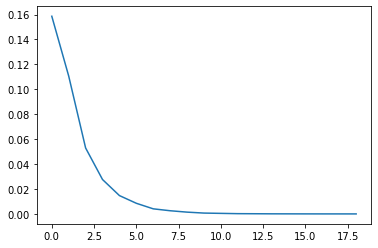

8.47350761391794e-06


In [41]:
plt.plot(MSE)
plt.show()
print(MSE[-1])

### Plot surface for different polynomial fits
Choosing a low p_interesting is less likely to cause overfitting. If the polynomial is overfitt, it tries to adapt to the noise in the model. 

Text(0.5, 0.92, 'Overfit model')

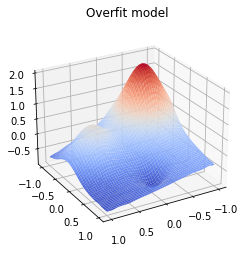

In [42]:
p_interesting = 17
model = OLS(x_cent[:, 0], y_cent[:, 0], z_cent[:, 0], p_interesting)
z_prediction = model.predict(x_cent[:, 0], y_cent[:, 0])
ax = plt.subplot(111, projection='3d')
ax.plot_surface(x_cent.reshape(z.shape), y_cent.reshape(z.shape), z_prediction.reshape(z.shape), cmap=cm.coolwarm)
ax.view_init(elev=25., azim=60)
ax.set_title('Overfit model')

 **Observations:** 
 - It seems like the polynomial model is a OK (but not perfect) aproximation to the franke function: 
 - Fitting a 20th degree polynomial to Franke Function with no noise does not yield a (much) better aproximation than a 40th degree polynomial. Thus it can seem as we have convergence, at least for these resolutions. The MSE behaves oddly for low resolution, this could be because a low resolution Franke Function is less smooth than a high resolution franke function.
 - Introducing Fr + noise the fit becomes worse, as expected.  
 - With no noise added to the Franke Function the polynomial seems to not overfitt, even if there is small errors that potetially could be overfittet. Adding noise makes the polynomial overfit for large polynomial degrees. Adding more noise makes the polynomial overfit for smaller polynomial degrees. 
 - R2: Behaves as expected (low for bad fits, high for good fits). I will mainly use MSE as a measurement of error throughout this project. 

In [43]:
print(R2s) 
print(MSE)

[0.7003617402026907, 0.7910471616578214, 0.9000206597276265, 0.9478589090109643, 0.9721886572179185, 0.983871713466633, 0.9922800453305304, 0.9951738605847369, 0.997284541626901, 0.9987135317018351, 0.9991553131962928, 0.9995952343473896, 0.9997131154345665, 0.9998442253022783, 0.9998880887809719, 0.9999339196789826, 0.9999587577609864, 0.9999701303142952, 0.999983992321895]
[0.15861057794640715, 0.11060713833878946, 0.05292308450205486, 0.02760037580688627, 0.01472166189696712, 0.00853735050414798, 0.0040864823893749, 0.002554669628713691, 0.0014374012926052257, 0.000680979393017769, 0.00044712668605915697, 0.00021425873363706862, 0.00015185953475397446, 8.24578104670884e-05, 5.923910765181197e-05, 3.497897069131334e-05, 2.1831175265051653e-05, 1.5811225562199508e-05, 8.47350761391794e-06]


### Variance in beta:
Here the expected variance in beta_i for different polynomials are plotted. We see clearly that the variance increases exponentially.

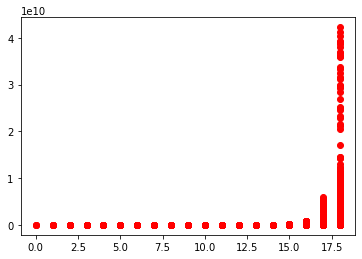

In [27]:
ax = plt.subplot(111)
for i in range(len(variance_beta)):
    for j in range(len(variance_beta[i])):
        ax.plot(i, variance_beta[i][j], 'ro')


### Plt beta_i and its confidence interval for different polynomial orders
We can see that as the polynomial degree is increased, so is the sigma 1 confidence interval for all individual beta values. An interpretation of this can be that for larger polynomials, beta values are used to fit the polynomial to noise. As the noise is randomly distributed there exists many good candidates to fit to this noise, thus betas with large confidence intervals used to compensate for other betas with large confidence intervals in a game where the goal is to fit the model to noise. Indeed, setting the noise level to zero yields lower confidence intervals as the beta values are more certain. However, for a large enought polynomial fit we can again see some uncertainty in the beta values. This is because the polynomial fit is not the perfect model for franke function (the perfect fit to franke function is franke function) and for large polynomials there are many ways to approximate the same function with increasingly more viable combinations of beta producing good estimates. 

In [44]:
%matplotlib inline

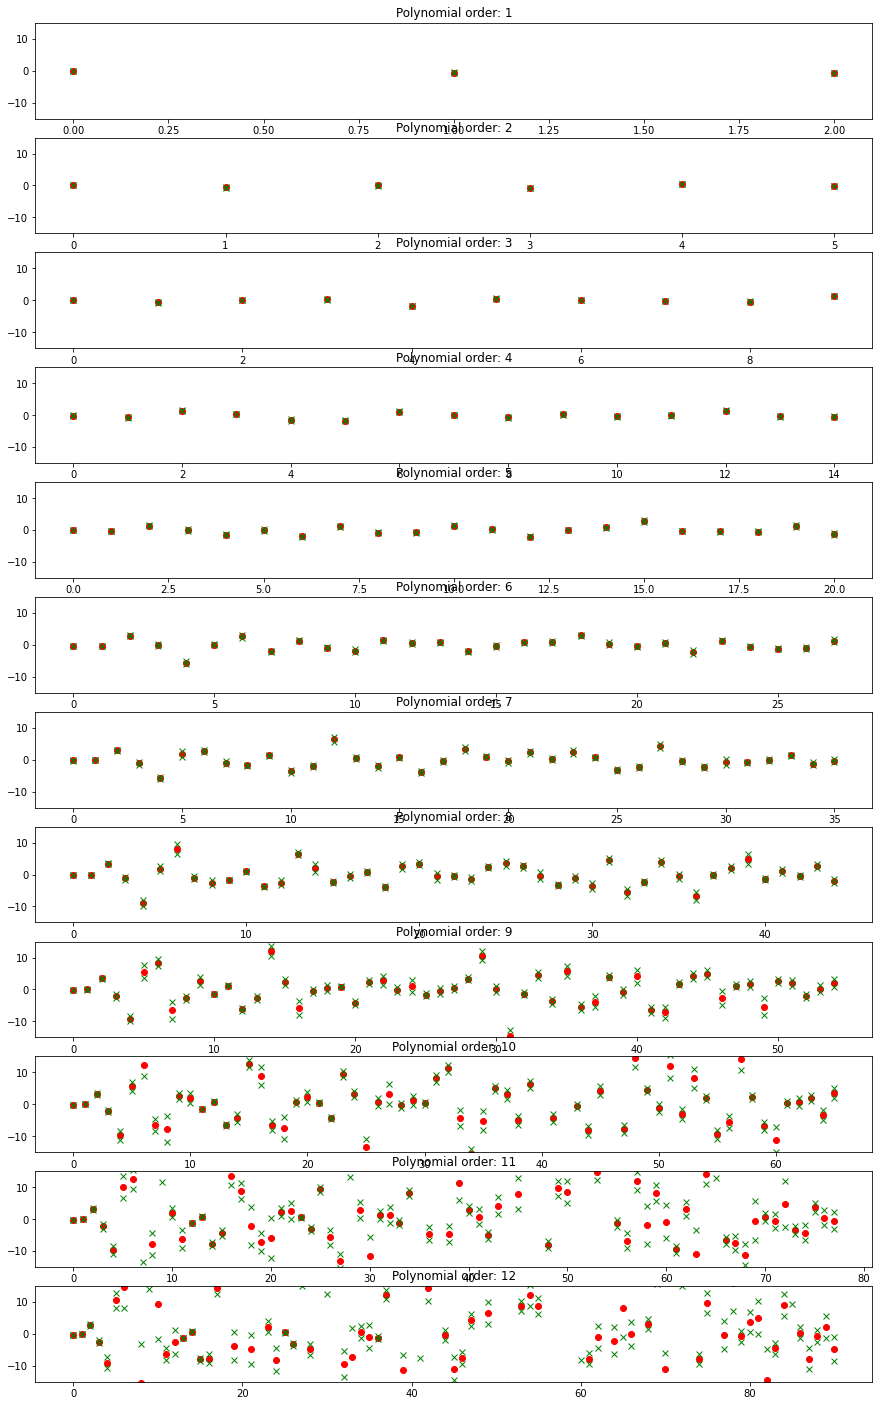

In [46]:
import matplotlib.pyplot as plt
n_polynom = 12

fig, axs = plt.subplots(n_polynom, 1, figsize=(15, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

sigma = 2
for polynom_nr in range(n_polynom):
    for beta_i in range(len(betas[polynom_nr])):
        axs[polynom_nr].plot(beta_i, betas[polynom_nr][
            beta_i], 'ro') #plot middle beta
        axs[polynom_nr].plot(beta_i, betas[polynom_nr][
            beta_i] + sigma*np.sqrt(variance_beta[polynom_nr][beta_i]), 'gx') 
        axs[polynom_nr].plot(beta_i, betas[polynom_nr][
            beta_i] - sigma*np.sqrt(variance_beta[polynom_nr][beta_i]), 'gx') 
    axs[polynom_nr].set_title('Polynomial order: ' + str(polynom_nr + 1))
    axs[polynom_nr].set_ylim([-15, 15])
    
# Kule funn:
# Vi antar (som rimelig er med normalfordelt støy...) at variansen til beta er normalfordelt. 
# Eg tolker dette som at ulike rader gir ulike estimat på beta. 
#
# Er ulike konfidensintervall relatert til den faktiske funksjonen me prøver å sjå på?
# At den endrer seg meir i y-retning enn i x-retning?